In [1]:
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import create_engine
from database import Reactions

engine = create_engine('sqlite:///reactions2.db', echo = False)

Session = sessionmaker(bind=engine)
session = Session()

2023-06-20 17:15:31,994 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-20 17:15:31,995 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("reactions")
2023-06-20 17:15:31,996 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-20 17:15:31,996 INFO sqlalchemy.engine.Engine COMMIT


In [2]:
eles = []
for k in r:
    sm = Chem.MolToSmiles(Chem.MolFromSmiles(k.electrophile))
    if sm not in eles:
        eles.append(sm)
for k in eles:
    print(k)

NameError: name 'r' is not defined

In [3]:
def getRxnFP(r, fp_type, summed, multipliers):
    if fp_type == "MACCS":
        rxnMatrix = np.zeros((5,167))
    else:
        rxnMatrix = np.zeros((5,2048))
    row = 0
    for k,m in zip(reagent_classes,multipliers):
        sm = getattr(r,k)
        if sm == "NONE":
            fp = np.zeros((1,))
        else:
            if k == "solvent":
                mol = Chem.MolFromSmiles(solv_map[sm])
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
                if "%" in sm:
                    s2 = sm.split("_")[1]
                    mol2 = Chem.MolFromSmiles(solv_map[s2])
                    fp2 = np.zeros((1,))
                    if fp_type == "MACCS":
                        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp2)
                    else:
                        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp2)

                    fp = np.add(fp,fp2)
            else:
                mol = Chem.MolFromSmiles(sm)
                fp = np.zeros((1,))
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
        fp = fp*m
        rxnMatrix[row,:] = fp
        row = row + 1
    if summed:
        return np.sum(rxnMatrix, axis=0)
    else:
        return rxnMatrix

In [4]:
r = session.query(Reactions).all()
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

# eles = ["BrC1=NC=CC(C2=CC(C(NCC3)=O)=C3N2)=C1", "FC(C=C1)=C(Cl)C=C1CN2C(C3=C(O)C(N(C(C)C)C(C(N(C)C)=O)=C3CC2)=O)=O", "CN1C(=O)C[C@@](C)(c2sccc2Cl)N/C1=N/C(=O)OC(C)(C)C"]
eles = ["O=C1NCCC2=C1C=C(C3=CC=NC(Br)=C3)N2"]
ele_mols = [Chem.MolToSmiles(Chem.MolFromSmiles(m)) for m in eles]
nucs = ["OB(C1=CC=CC=C1)O"]
nuc_mols = [Chem.MolToSmiles(Chem.MolFromSmiles(m)) for m in nucs]

multipliers = [1, 3, 0, 0, 0]
rxnfps = []
yields = []
data = {k:[] for k in reagent_classes}
smiles_to_name = {}
smiles_to_yields = {}
types = {k:[] for k in reagent_classes}
type_lists = {k:[] for k in reagent_classes}
reag_to_yields = {}
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    # print(k.electrophile)
    # if Chem.MolToSmiles(Chem.MolFromSmiles(k.electrophile)) not in ele_mols:
        # continue
    # if Chem.MolToSmiles(Chem.MolFromSmiles(k.nucleophile)) not in nuc_mols:
        # continue
    print(k.solvent)
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)
    n = k.group
    if n == "0":
        yields.append(0)
    elif n == "low":
        yields.append(1)
    elif n == "med":
        yields.append(2)
    else:
        yields.append(3)
        # print("yo")
    for i,j in enumerate(reagent_classes):
        if j == "solvent":
            sm = Chem.MolToSmiles(Chem.MolFromSmiles(solv_map[getattr(k,j)]))
        else:
            sm = Chem.MolToSmiles(Chem.MolFromSmiles(getattr(k,j)))
        if sm not in reag_to_yields:
            reag_to_yields[sm] = []
        reag_to_yields[sm].append(yields[-1])
        data[j].append(sm)
        if j == "catalyst_smiles":
            smiles_to_name[sm] = k.catalyst
            if sm not in smiles_to_yields:
                smiles_to_yields[sm] = []
            # smiles_to_yields[getattr(k,j)].append(k.
        if j == "base_smiles":
            smiles_to_name[sm] = k.base
        types[j].append(sm)
        if sm not in type_lists[j]:
            type_lists[j].append(sm)
print(len(rxnfps), len(yields))

/var/folders/8k/w__0g4xs7rj0xv7hk3dqm71w0000gn/T/ipykernel_26655/1517153051.py:1: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  r = session.query(Reactions).all()


25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO


In [5]:
print(np.mean(yields))

1.6651112706389088


In [6]:
for k in reag_to_yields:
    # print(k, np.mean(reag_to_yields[k]))
    if np.mean(reag_to_yields[k]) == 0:
        print(k)

CN1C(=O)C[C@@](C)(c2sccc2Cl)N/C1=N/C(=O)OC(C)(C)C


In [7]:
from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA

X_TSNE_RFP_SOLVENT_3 = TSNE(n_components=2, n_jobs=-1, perplexity=20, random_state=1).fit_transform(rxnfps)
# X_TSNE_RFP_SOLVENT_3 = PCA(n_components=2).fit_transform(rxnfps)

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [10]:
data["x_solvent"] = []
data["y_solvent"] = []
for k in X_TSNE_RFP_SOLVENT_3[:,0]:
    data["x_solvent"].append(k) 
for k in X_TSNE_RFP_SOLVENT_3[:,1]:
    data["y_solvent"].append(k)
for k in reagent_classes:
    print(len(data[k]))
print(len(data["x_solvent"]))
print(len(data["y_solvent"]))
df = pd.DataFrame(data)

2786
2786
2786
2786
2786
2786
2786


In [11]:
types_one_hot = {k:[] for k in reagent_classes}

for k in reagent_classes:
    for j in types[k]:
        types_one_hot[k].append(type_lists[k].index(j))

# types_one_hot = [type_lists["solvent"].index(k) for k in df["solvent"]]
# types_one_hot2 = [type_lists["base_smiles"].index(k) for k in types["base_smiles"]]

# for k in type_list:
    # print(k)

In [12]:
for k in type_lists:
    print(k, len(type_lists[k]))
print(type_lists["electrophile"][0])
print(type_lists["nucleophile"][5])

electrophile 16
nucleophile 33
catalyst_smiles 18
base_smiles 10
solvent 8
O=C1NCCc2[nH]c(-c3ccnc(Br)c3)cc21
OB(O)c1ccccc1


In [13]:
import matplotlib

cmap = matplotlib.cm.get_cmap("inferno")

# for k in type_lists["solvent"]:
#     print(k, matplotlib.colors.to_hex(cmap(type_lists["solvent"].index(k)/(len(type_lists["solvent"])-1))))
    
# for k in type_lists["base_smiles"]:
#     print(k, matplotlib.colors.to_hex(cmap(type_lists["base_smiles"].index(k)/(len(type_lists["base_smiles"])-1))))

for k in type_lists["catalyst_smiles"]:
    print(k, smiles_to_name[k], matplotlib.colors.to_hex(cmap(type_lists["catalyst_smiles"].index(k)/(len(type_lists["catalyst_smiles"])-1))))


CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1.CS(=O)(=O)O[Pd]c1ccccc1-c1ccccc1N XPhos Pd G3 #000004
CC(C)(C)P(C(C)(C)C)C(C)(C)C.Nc1ccccc1-c1ccccc1[Pd]Cl tBu3P Pd G2 #0a0722
COc1cccc(OC)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.CS(=O)(=O)O[Pd]c1ccccc1-c1ccccc1N SPhos Pd G2 #1e0c45
CC(C)Oc1cccc(OC(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.CS(=O)(=O)O[Pd]c1ccccc1-c1ccccc1N RuPhos Pd G3 #380962
CC(C)c1cc(C(C)C)c(-c2ccccc2P(C(C)(C)C)C(C)(C)C)c(C(C)C)c1.CS(=O)(=O)O[Pd]c1ccccc1-c1ccccc1N tBuXPhos Pd G3 #510e6c
CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.CS(=O)(=O)O[Pd]c1ccccc1-c1ccccc1N.[Fe] DTBPF Pd G3 #69166e
COc1ccc(OC)c(P(C2CCCCC2)C2CCCCC2)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C.CS(=O)(=O)O[Pd]c1ccccc1-c1ccccc1N BrettPhos Pd G3 #801f6c
CN(C)c1ccc(P(C(C)(C)C)C(C)(C)C)cc1.CS(=O)(=O)O[Pd]c1ccccc1-c1ccccc1N APhos Pd G3 #982766
CS(=O)(=O)O[Pd]c1ccccc1-c1ccccc1N.c1ccc(P(c2ccccc2)c2ccc3ccccc3c2-c2c(P(c3ccccc3)c3ccccc3)ccc3ccccc23)cc1 BINAP Pd G3 #b0315b
CS(=O)(=O)O[Pd]c1cc

In [14]:
col = ["#080709", "#2C2058", "#62266C", "#A12A63", "#D64943", "#F47E20", "#F9C22A", "#F7F3A9"]
col_in = []
for k in types_one_hot:
    col_in.append(col[k])

TypeError: list indices must be integers or slices, not str

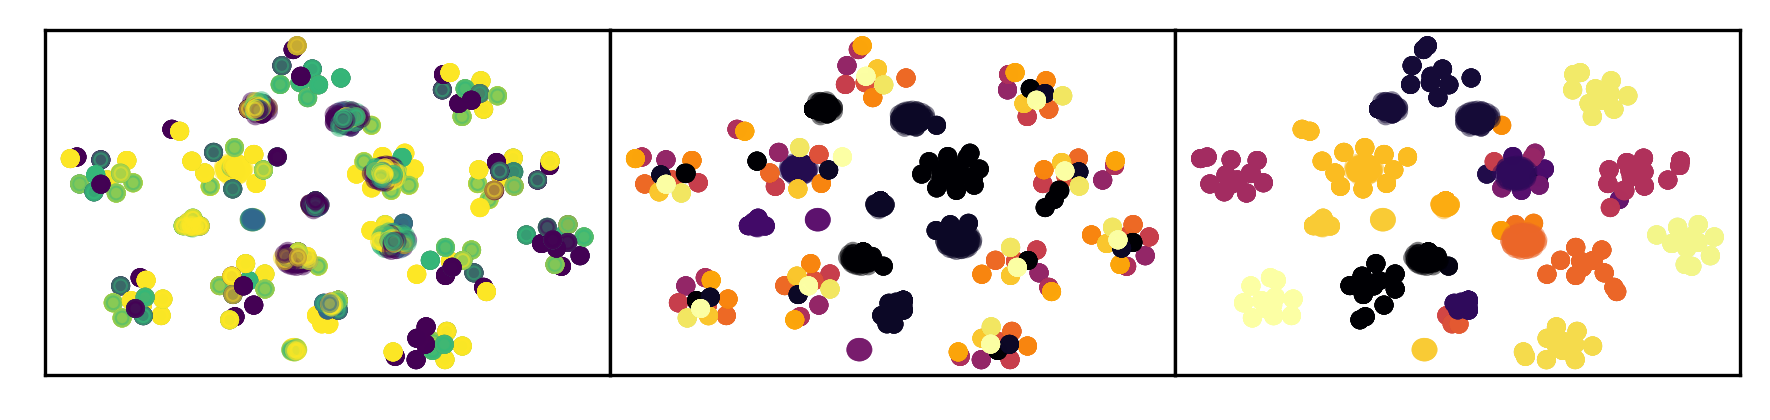

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(6,1.5), dpi=300)


ax[0].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])

# for i,n in enumerate(types_one_hot["nucleophile"]):
#     ax[2].text(X_TSNE_RFP_SOLVENT_3[i,0], X_TSNE_RFP_SOLVENT_3[i,1], s=n, fontsize=3)


ax[2].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='inferno', c=types_one_hot["nucleophile"], alpha=.5, marker='.',s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])

# for i,n in enumerate(types_one_hot["electrophile"]):
#     ax[1].text(X_TSNE_RFP_SOLVENT_3[i,0], X_TSNE_RFP_SOLVENT_3[i,1], s=n, fontsize=3)

ax[1].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='inferno', c=types_one_hot["electrophile"], alpha=.5, marker='.',s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])

# ax[3].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='inferno', c=types_one_hot["solvent"], alpha=.5, marker='.',s=5)
# ax[3].set_xticks([])
# ax[3].set_yticks([])

# ax[2].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='inferno', c=types_one_hot["base_smiles"], alpha=.5, marker='.',s=5)
# ax[2].set_xticks([])
# ax[2].set_yticks([])


# ax[1].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='inferno', c=types_one_hot["catalyst_smiles"], alpha=.5, marker='.',s=5)
# ax[1].set_xticks([])
# ax[1].set_yticks([])



# ax[0].legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figure_components/top.png', dpi=300, bbox_inches='tight', pad_inches=0.01)

In [17]:
r = session.query(Reactions).all()
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

# eles = ["BrC1=NC=CC(C2=CC(C(NCC3)=O)=C3N2)=C1", "FC(C=C1)=C(Cl)C=C1CN2C(C3=C(O)C(N(C(C)C)C(C(N(C)C)=O)=C3CC2)=O)=O", "CN1C(=O)C[C@@](C)(c2sccc2Cl)N/C1=N/C(=O)OC(C)(C)C"]
eles = ["O=C1NCCC2=C1C=C(C3=CC=NC(Br)=C3)N2"]
ele_mols = [Chem.MolToSmiles(Chem.MolFromSmiles(m)) for m in eles]
nucs = ["OB(C1=CC=CC=C1)O"]
nuc_mols = [Chem.MolToSmiles(Chem.MolFromSmiles(m)) for m in nucs]

multipliers = [0, 0, 3, 1, 3]
rxnfps = []
yields = []
data = {k:[] for k in reagent_classes}
smiles_to_name = {}
smiles_to_yields = {}
types = {k:[] for k in reagent_classes}
type_lists = {k:[] for k in reagent_classes}
reag_to_yields = {}
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    # print(k.electrophile)
    if Chem.MolToSmiles(Chem.MolFromSmiles(k.electrophile)) not in ele_mols:
        continue
    if Chem.MolToSmiles(Chem.MolFromSmiles(k.nucleophile)) not in nuc_mols:
        continue
    print(k.solvent)
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)
    n = k.group
    if n == "0":
        yields.append(0)
    elif n == "low":
        yields.append(1)
    elif n == "med":
        yields.append(2)
    else:
        yields.append(3)
        # print("yo")
    for i,j in enumerate(reagent_classes):
        if j == "solvent":
            sm = Chem.MolToSmiles(Chem.MolFromSmiles(solv_map[getattr(k,j)]))
        else:
            sm = Chem.MolToSmiles(Chem.MolFromSmiles(getattr(k,j)))
        if sm not in reag_to_yields:
            reag_to_yields[sm] = []
        reag_to_yields[sm].append(yields[-1])
        data[j].append(sm)
        if j == "catalyst_smiles":
            smiles_to_name[sm] = k.catalyst
            if sm not in smiles_to_yields:
                smiles_to_yields[sm] = []
            # smiles_to_yields[getattr(k,j)].append(k.
        if j == "base_smiles":
            smiles_to_name[sm] = k.base
        types[j].append(sm)
        if sm not in type_lists[j]:
            type_lists[j].append(sm)
print(len(rxnfps), len(yields))
types_one_hot = {k:[] for k in reagent_classes}

for k in reagent_classes:
    for j in types[k]:
        types_one_hot[k].append(type_lists[k].index(j))

# types_one_hot = [type_lists["solvent"].index(k) for k in df["solvent"]]
# types_one_hot2 = [type_lists["base_smiles"].index(k) for k in types["base_smiles"]]

# for k in type_list:
    # print(k)

25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
25%H2O_DMSO
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
10%tAmOH_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
25%H2O_NMP
2

In [18]:
from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA

X_TSNE_RFP_SOLVENT_3 = TSNE(n_components=2, n_jobs=-1, perplexity=20, random_state=1).fit_transform(rxnfps)
# X_TSNE_RFP_SOLVENT_3 = PCA(n_components=2).fit_transform(rxnfps)

/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


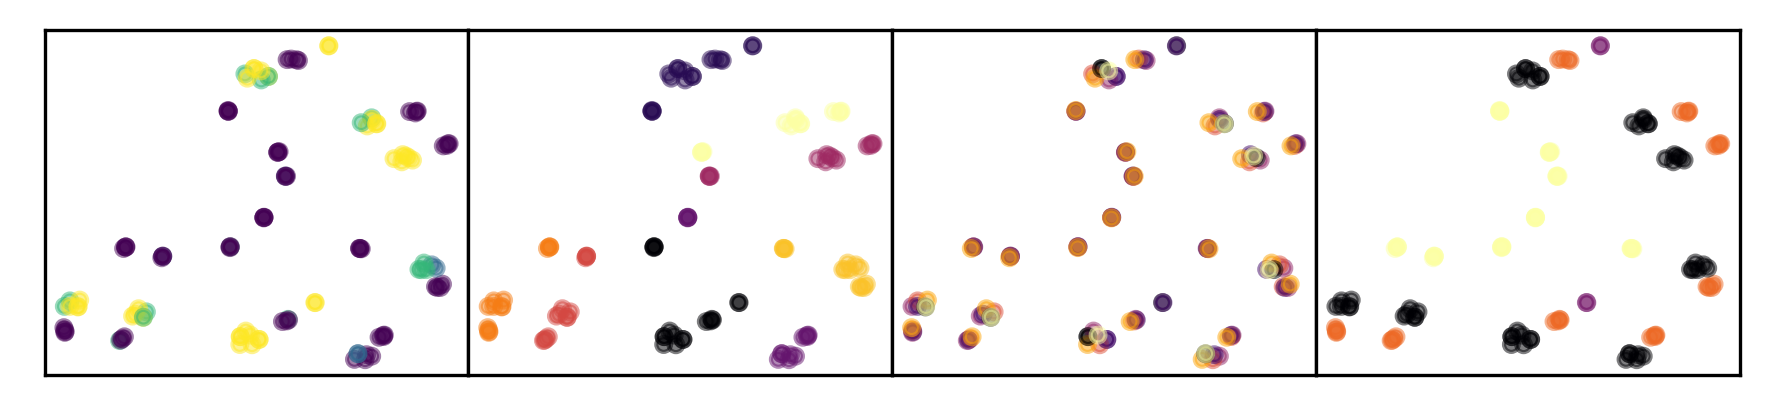

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,4,figsize=(6,1.5), dpi=300)


ax[0].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])

# for i,n in enumerate(types_one_hot["nucleophile"]):
#     ax[2].text(X_TSNE_RFP_SOLVENT_3[i,0], X_TSNE_RFP_SOLVENT_3[i,1], s=n, fontsize=3)


# ax[2].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='plasma', c=types_one_hot["nucleophile"], alpha=.5, marker='.',s=5)
# ax[2].set_xticks([])
# ax[2].set_yticks([])

# for i,n in enumerate(types_one_hot["electrophile"]):
#     ax[1].text(X_TSNE_RFP_SOLVENT_3[i,0], X_TSNE_RFP_SOLVENT_3[i,1], s=n, fontsize=3)

# ax[1].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='plasma', c=types_one_hot["electrophile"], alpha=.5, marker='.',s=5)
# ax[1].set_xticks([])
# ax[1].set_yticks([])

ax[3].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='inferno', c=types_one_hot["solvent"], alpha=.5, marker='.',s=50)
ax[3].set_xticks([])
ax[3].set_yticks([])

ax[2].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='inferno', c=types_one_hot["base_smiles"], alpha=.5, marker='.',s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])


ax[1].scatter(X_TSNE_RFP_SOLVENT_3[:,0], X_TSNE_RFP_SOLVENT_3[:,1], cmap='inferno', c=types_one_hot["catalyst_smiles"], alpha=.5, marker='.',s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])



# ax[0].legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figure_components/bottom.png', dpi=300, bbox_inches='tight', pad_inches=0.01)

In [111]:
solvent_yields = {}
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    if Chem.MolToSmiles(Chem.MolFromSmiles(k.electrophile)) != Chem.MolToSmiles(Chem.MolFromSmiles("BrC1=NC=CC(C2=CC3=C(N2)CCNC3=O)=C1")):
        continue
    if k.output_value > 100:
        continue
    if k.solvent not in solvent_yields:
        solvent_yields[k.solvent] = []
    solvent_yields[k.solvent].append(float(k.output_value))
    # print(k.solvent)

In [112]:
print(len(solvent_yields))

6


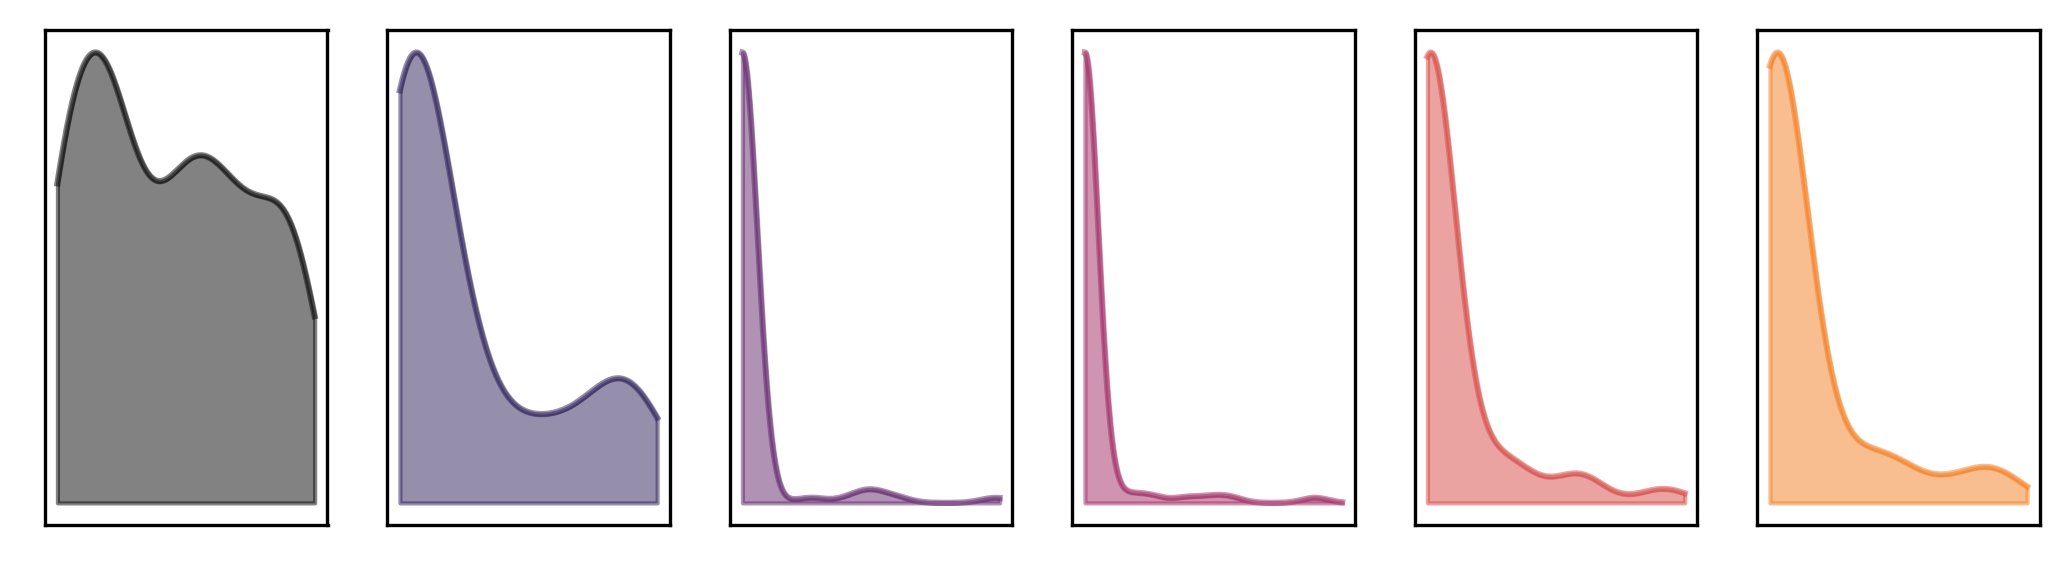

In [114]:
import numpy as np
from scipy import stats

fig, ax = plt.subplots(1, 6, figsize=(7,2), dpi=300)

for i,k in enumerate(solvent_yields):
    kernel = stats.gaussian_kde(solvent_yields[k])
    x = np.arange(0,np.max(solvent_yields[k])+1,.01)
    y = kernel(x)
    ax[i].plot(x,y, alpha=0.5, c=col[i])
    ax[i].fill_between(x,y,0, color=col[i], interpolate=True, alpha=0.5)

    ax[i].set_yticks([])
    ax[i].set_xticks([])
    # plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"solvent_kde.png",dpi=900, bbox_inches='tight',pad_inches=0.0)
    # break
